In [30]:
from pathlib import Path
import pickle
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns

import nb_utils

In [2]:
def features_for_dim(pd, dim):
	# b: birth, d: death
	b, d, _ = pd[pd[:,2] == dim].T
	if dim == 0:
		assert d[-1] == np.inf
		d[-1] = 1
	with np.errstate(invalid='ignore', divide='ignore'):
		return [
			mean_bd := np.c_[b, d].mean(axis=0),
			mean_bd**2,
			np.nan_to_num(1/mean_bd + np.log(mean_bd)), # fix divide by zero
			np.c_[b, d].std(axis=0),
			[np.mean(b - d)],
			[np.mean(b - d)**2],
			[np.mean((b + d) / 2)],
			[np.mean((b + d) / 2)**2],
		]

features = {
	'avg_birth_death': 2,
	'avg_birth_death_squared': 2,
	'avg_birth_death_inverted' : 2,
	'std_birth_death': 2,
	'avg_life': 1,
	'avg_life_squared': 1,
	'avg_half_life': 1,
	'avg_half_life_squared': 1
}

combinations = [*itertools.chain(*(
	itertools.combinations(features.keys(), r)
	for r in range(1, len(features) + 1)
))]

def features_all_dims(pd):
	arrs = [np.concatenate(features_for_dim(pd, dim)) for dim in (0, 1)]
	return np.vstack(arrs)

In [3]:
def get_labeled_data(task, files):
	gen_gaps = nb_utils.gen_gaps[task]
	pds = [*map(np.load, files)]
	X = np.stack([*map(features_all_dims, pds)])
	y = np.array([gen_gaps[f.name.split('.')[0]] for f in files])
	return X, y

In [4]:
def feature_mask(included):
	return np.concatenate([
		np.full(length, 1 if feature in included else 0)
		for feature, length in features.items()
	])

def run_experiment(X, y, tries, model_fn):
	results = np.empty((len(combinations), tries))
	splits = [*ShuffleSplit(tries, test_size=0.3).split(X)]
	for i, combo in enumerate(tqdm(combinations)):
		X_masked = X[:,:,np.where(feature_mask(combo))[0]]
		X_flattened = X_masked.reshape((len(X), -1))
		for j, (train, test) in enumerate(splits):
			reg = model_fn().fit(X_flattened[train], y[train])
			results[i, j] = reg.score(X_flattened[test], y[test])
	return results

## Model performance
We look at the model performance for the model with the best performing selection of features (by average R2) and at the models incorporating all features

In [5]:
def extract_best(results, ):
	return max(results, key=np.mean)

def extract_all(results):
	return results[-1]

In [6]:
def results_for_sampler(task, files: list[Path]):
	task_name_date = files[0].parts[-4:-1]
	results_file = Path('results') / ("-".join(task_name_date) + '.npy')
	try:
		return np.load(results_file)
	except FileNotFoundError:
		print('Calculating', '/'.join(task_name_date))
		X, y = get_labeled_data(task, files)
		results = run_experiment(X, y, 1000, LinearRegression)
		np.save(results_file, results)
		return results

def results_all_samplers(task):
	samplers, files_task = zip(*nb_utils.get_files(task))
	results = np.array(
		[results_for_sampler(1, files_sampler) for files_sampler in files_task])
	return results, samplers

In [7]:
samplers, files_task = zip(*nb_utils.get_files(1))
results = np.array(
	[results_for_sampler(1, files_sampler) for files_sampler in files_task])

In [8]:
pd.DataFrame({
	'All features': [np.mean(extract_all(res)) for res in results],
	'Best features': [np.mean(extract_best(res)) for res in results]
}, index=samplers)

,All features,Best features
AvgImportance,0.600350,0.719903
MaxImportance,0.723637,0.788833
Random,0.771025,0.815547
StratifiedKMeans20000,0.780958,0.824686
StratifiedRandom,0.746796,0.796928


### KDE plots

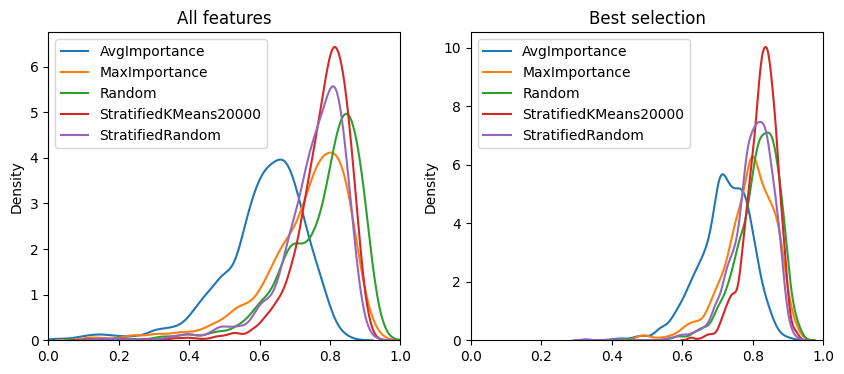

In [100]:
def plot_kdes(results, samplers=None, bw=0.2, figsize=(10, 4)):
	fig, axs = plt.subplots(1, 2, figsize=figsize)
	types = {'All features': extract_all, 'Best selection': extract_best}
	for ax, (title, extract) in zip(axs, types.items()):
		dists = [extract(results) for results in results]
		for i, dist in enumerate(dists):
			dist = dist[dist > 0]
			sampler = samplers[i] if samplers else None
			ax = sns.kdeplot(dist, ax=ax, bw_method=bw, label=sampler)
		if samplers:
			ax.legend()
		ax.set_xlim([0,1])
		ax.set_title(title)
	return fig, axs

plot_kdes(results, samplers)
plt.show()

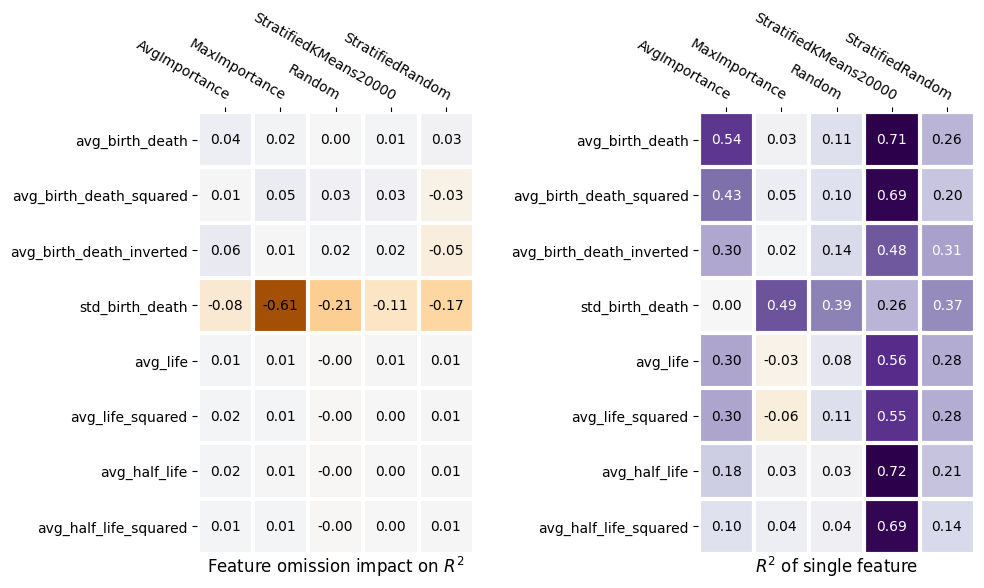

In [90]:
from importlib import reload
reload(nb_utils)

def heatmap_r2(results, samplers=None, wspace=0.6):
	one_removed_r2s = np.mean(results[:,-2:-len(features)-2:-1], axis=2)
	heatmaps = [
		one_removed_r2s - np.mean(results[:,[-1]], axis=2),
		np.mean(results[:,:len(features)], axis=2)
	]

	fig, axs = plt.subplots(1, 2, figsize=(10, 6))
	titles = [
		"Feature omission impact on $R^2$",
		"$R^2$ of single feature"
	]

	maxval = np.abs(heatmaps).max()
	norm = colors.Normalize(-maxval, maxval)
	for i in 0, 1:
		im, _ = nb_utils.heatmap(heatmaps[i].T, features.keys(), samplers,
								ax=axs[i], cmap='PuOr', norm=norm)
		nb_utils.annotate_heatmap(im, threshold=0.3)
		axs[i].set_title(titles[i], y=-0.06)

	fig.tight_layout()
	plt.subplots_adjust(wspace=wspace)
	return fig, axs

heatmap_r2(results, samplers, wspace=0.6)
plt.show()

In [95]:
def best_selection_table(results, samplers):
	data = {
		sampler: [f in combinations[np.argmax(np.mean(results, 1))] for f in features]
		for sampler, results in zip(samplers, results)
	}
	return pd.DataFrame(data, index=features.keys()).replace({True: 'X', False: ''})

best_selection_table(results, samplers)

,AvgImportance,MaxImportance,Random,StratifiedKMeans20000,StratifiedRandom
avg_birth_death,,X,X,,
avg_birth_death_squared,X,,,X,X
avg_birth_death_inverted,,X,X,X,X
std_birth_death,X,X,X,X,X
avg_life,X,X,X,,X
avg_life_squared,,X,,,
avg_half_life,X,,,,
avg_half_life_squared,,X,X,X,X


In [103]:
results_random = [
	results_for_sampler(1, files)
	for files in nb_utils.get_files(1, sampler='Random')
]

pd.DataFrame({
	'All features': [np.mean(extract_all(res)) for res in results_random],
	'Best features': [np.mean(extract_best(res)) for res in results_random]
}, index=samplers)

Calculating task1/Random/22.12.30-18.47.09


 25%|██▍       | 63/255 [01:57<08:47,  2.75s/it]

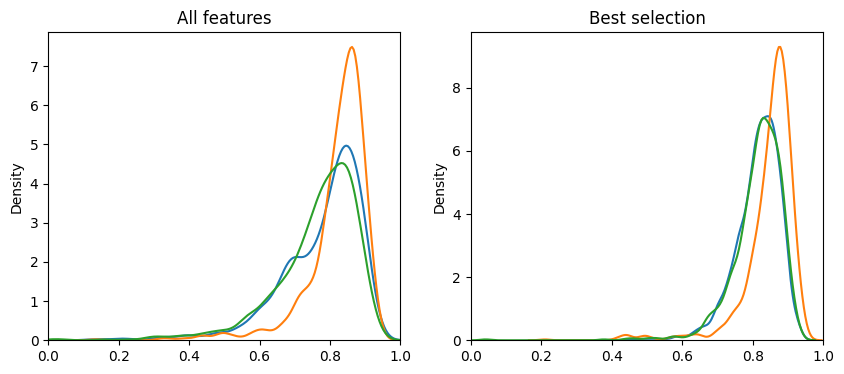

In [102]:
plot_kdes(results_random, bw=0.2)
plt.show()

In [21]:
results = {
	sampler: results_for_sampler(2, files)
	for sampler, files in nb_utils.get_files(2)
}

pd.DataFrame({
	'All features': [np.mean(extract_all(res)) for res in results.values()],
	'Best features': [np.mean(extract_best(res)) for res in results.values()]
}, index=results.keys())

Calculating task2/StratifiedRandom/22.12.30-16.27.14


100%|██████████| 255/255 [09:38<00:00,  2.27s/it]


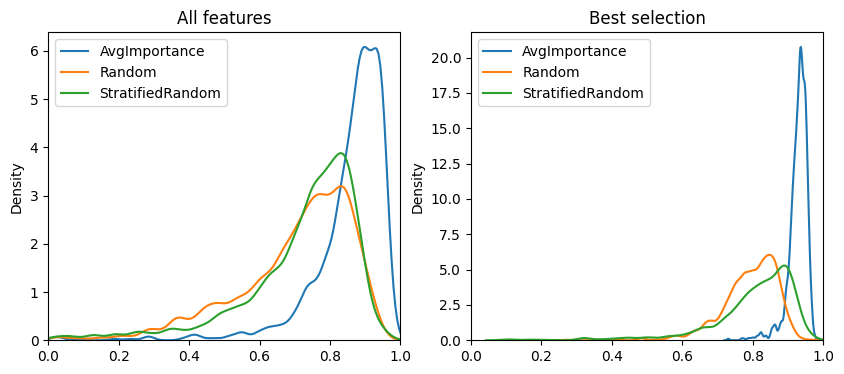

In [23]:
### KDE plots
def plot_kdes(samplers, dists, bw=None, ax=None):
	for sampler, dist in zip(samplers, dists):
		dist = dist[dist > 0]
		bw_factor = bw
		ax = sns.kdeplot(dist, ax=ax, bw_method='silverman', bw_adjust=bw_factor, label=sampler)
	ax.legend()
	ax.set_xlim([0,1])
	return ax

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
types = {'All features': extract_all, 'Best selection': extract_best}
for ax, (title, extract) in zip(axs, types.items()):
	plot_kdes(samplers=list(results.keys()),
			dists=[extract(results) for results in results.values()],
			ax=ax, bw=0.5)
	ax.set_title(title)

In [24]:
import pandas as pd

data = {
	sampler: [f in combinations[np.argmax(np.mean(results, 1))] for f in features]
	for sampler, results in results.items()
}
pd.DataFrame(data, index=features.keys()).replace({True: 'X', False: ''})

,AvgImportance,Random,StratifiedRandom
avg_birth_death,,,
avg_birth_death_squared,X,,
avg_birth_death_inverted,,,X
std_birth_death,,X,X
avg_life,X,,X
avg_life_squared,,X,X
avg_half_life,,X,X
avg_half_life_squared,,,X


In [26]:
from statistics import mean

heatmap = np.zeros((len(results), len(features)))
for i, (sampler, res) in enumerate(results.items()):
	for j, feature in enumerate(features):
		r2s = itertools.chain(
			*(res[i] for i, combo in enumerate(combinations) if feature in combo))
		heatmap[i][j] = mean(r2s)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Average R2 of selections with feature present'}>)

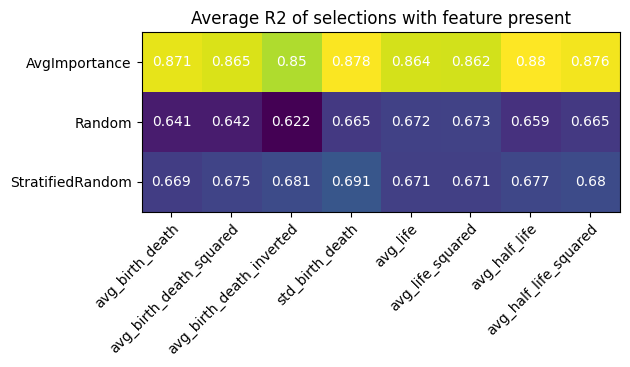

In [27]:
from importlib import reload
reload(nb_utils)

nb_utils.annotated_heatmap(heatmap,
						   title="Average R2 of selections with feature present",
						   x_labels=features.keys(),
						   y_labels=results.keys())